* 该notebook复习使用keras搭建一个mini-vgg并完成分类任务

In [12]:
import os
from keras.datasets import cifar10
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import multi_gpu_model
from keras import backend as K
import matplotlib.pyplot as plt

## Step0: DataLoader

In [3]:
def loadCifar():
    (trainX, trainY),(testX, testY) = cifar10.load_data()
    trainX = trainX.astype("float") / 255
    testX = testX.astype("float") / 255
    lb = LabelBinarizer()
    trainY = lb.fit_transform(trainY)
    testY = lb.fit_transform(testY)
    labelNames = ["airplane", "automobile", "bird", "cat", "deer", 
                  "dog", "frog", "horse", "ship", "truck"]
    return (trainX, trainY), (testX, testY), labelNames

## Step1：Build Model

  Overall, MiniVGGNet consists of two sets of CONV => RELU => CONV => RELU => POOL
layers, followed by a set of FC => RELU => FC => SOFTMAX layers.   
  The first two CONV layers will learn 32 filters, each of size 3x3. The second two CONV layers will learn 64 filters, again, each
of size 3x3.   
  Our POOL layers will perform max pooling over a 2x2 window with a 2x2 stride.  
  We’ll also be inserting batch normalization layers after the activations along with dropout layers
(DO) after the POOL and FC layers.

In [12]:
class MiniVGGNet:
    @staticmethod  # 静态方法: 无需实例化即可调用类中的方法
    def build(width, height, depth, classes):
        chanDim=-1
        inputShape=(height, width, depth)
        
        if K.image_data_format == "channel_first":
            inputShape = (depth, height, width)
            chanDim=1
        
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same',input_shape=inputShape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(strides=2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(strides=2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

In [13]:
#regular check
# model = MiniVGGNet.build(32,32,3,10)
# from keras.utils import plot_model
# plot_model(model, 'model.png')

### Step2: Train Loop

In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.optimizers import SGD
import numpy as np

In [5]:
def train(trainX, trainY, testX, testY, lr=0.01, num_epochs=40, classes=10, labelNames=None):
    optimizer = SGD(lr=lr, decay=lr/num_epochs, momentum=0.9, nesterov=True)  #使用默认的decay方法
    model = MiniVGGNet.build(32, 32, 3, classes)
    parallel_model = multi_gpu_model(model, gpus=2)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    print("[INFO] training network...")
    H = model.fit(trainX, trainY, 64, num_epochs, validation_data=(testX, testY), verbose=1)
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=128)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(num_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(num_epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(num_epochs), H.history["acc"], label="acc")
    plt.plot(np.arange(num_epochs), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on CIFAR-10")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("training_curve.png")
    

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 12s 231us/step - loss: 1.6047 - acc: 0.4666 - val_loss: 1.2198 - val_acc: 0.5780
Epoch 2/40
50000/50000 [==============================] - 9s 174us/step - loss: 1.1480 - acc: 0.6026 - val_loss: 0.9575 - val_acc: 0.6670
Epoch 3/40
50000/50000 [==============================] - 9s 172us/step - loss: 0.9716 - acc: 0.6612 - val_loss: 0.9483 - val_acc: 0.6646
Epoch 4/40
50000/50000 [==============================] - 9s 175us/step - loss: 0.8559 - acc: 0.7007 - val_loss: 0.7902 - val_acc: 0.7232
Epoch 5/40
50000/50000 [==============================] - 9s 173us/step - loss: 0.7810 - acc: 0.7265 - val_loss: 0.7106 - val_acc: 0.7550
Epoch 6/40
50000/50000 [==============================] - 9s 174us/step - loss: 0.7203 - acc: 0.7480 - val_loss: 0.6754 - val_acc: 0.7622
Epoch 7/40
50000/50000 [==============================] - 9s 176us/step - loss: 0.6727 - acc: 

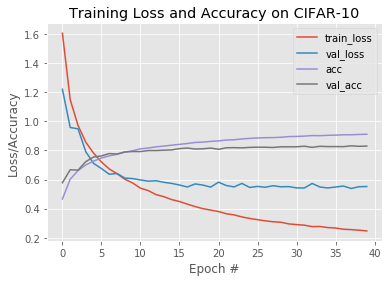

In [16]:
if __name__ == "__main__":
    (trainX, trainY), (testX, testY), labelNames = loadCifar()
    train(trainX, trainY, testX, testY, labelNames=labelNames)

### 实验二：去掉conv层的dropout

In [3]:
class MiniVGGNet:
    @staticmethod  # 静态方法: 无需实例化即可调用类中的方法
    def build(width, height, depth, classes):
        chanDim=-1
        inputShape=(height, width, depth)
        
        if K.image_data_format == "channel_first":
            inputShape = (depth, height, width)
            chanDim=1
        
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same',input_shape=inputShape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(strides=2))
        
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(strides=2))
        
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 11s 219us/step - loss: 1.5749 - acc: 0.4751 - val_loss: 1.2201 - val_acc: 0.5772
Epoch 2/40
50000/50000 [==============================] - 9s 171us/step - loss: 1.0449 - acc: 0.6396 - val_loss: 0.8972 - val_acc: 0.6889
Epoch 3/40
50000/50000 [==============================] - 8s 170us/step - loss: 0.8392 - acc: 0.7086 - val_loss: 0.8243 - val_acc: 0.7097
Epoch 4/40
50000/50000 [==============================] - 9s 171us/step - loss: 0.7298 - acc: 0.7440 - val_loss: 0.7369 - val_acc: 0.7455
Epoch 5/40
50000/50000 [==============================] - 8s 170us/step - loss: 0.6294 - acc: 0.7786 - val_loss: 0.7370 - val_acc: 0.7471
Epoch 6/40
50000/50000 [==============================] - 9s 172us/step - loss: 0.5581 - acc: 0.8039 - val_loss: 0.6716 - val_acc: 0.7691
Epoch 7/40
50000/50000 [==============================] - 9s 172us/step - loss: 0.4852 - acc: 

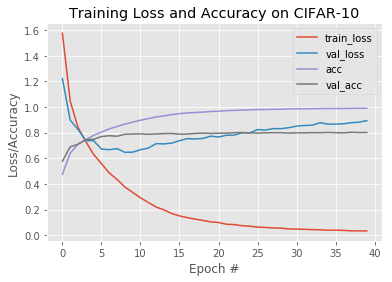

In [7]:
if __name__ == "__main__":
    (trainX, trainY), (testX, testY), labelNames = loadCifar()
    train(trainX, trainY, testX, testY, labelNames=labelNames)

### 实验三：去掉BN和Dropout

In [7]:
class MiniVGGNet:
    @staticmethod 
    def build(width, height, depth, classes):
        chanDim=-1
        inputShape=(height, width, depth)
        
        if K.image_data_format == "channel_first":
            inputShape = (depth, height, width)
            chanDim=1
        
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same',input_shape=inputShape))
        model.add(Activation('relu'))
        #model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(strides=2))
        #model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling2D(strides=2))
        #model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        #model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

In [9]:
def train1(trainX, trainY, testX, testY, lr=0.01, num_epochs=40, classes=10, labelNames=None):
    optimizer = SGD(lr=lr, decay=0, momentum=0.9, nesterov=False)  #使用默认的decay方法
    model = MiniVGGNet.build(32, 32, 3, classes)
    parallel_model = multi_gpu_model(model, gpus=2)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    print("[INFO] training network...")
    H = model.fit(trainX, trainY, 64, num_epochs, validation_data=(testX, testY), verbose=1)
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=128)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(num_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(num_epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(num_epochs), H.history["acc"], label="acc")
    plt.plot(np.arange(num_epochs), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on CIFAR-10")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("training_curve.png")
    

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 7s 132us/step - loss: 1.6810 - acc: 0.3894 - val_loss: 1.3683 - val_acc: 0.5097
Epoch 2/40
50000/50000 [==============================] - 6s 127us/step - loss: 1.1739 - acc: 0.5823 - val_loss: 1.0545 - val_acc: 0.6285
Epoch 3/40
50000/50000 [==============================] - 7s 132us/step - loss: 0.9056 - acc: 0.6823 - val_loss: 0.9273 - val_acc: 0.6760
Epoch 4/40
50000/50000 [==============================] - 7s 132us/step - loss: 0.7089 - acc: 0.7541 - val_loss: 0.8974 - val_acc: 0.6976
Epoch 5/40
50000/50000 [==============================] - 7s 132us/step - loss: 0.5376 - acc: 0.8125 - val_loss: 0.8439 - val_acc: 0.7201
Epoch 6/40
50000/50000 [==============================] - 7s 132us/step - loss: 0.3658 - acc: 0.8714 - val_loss: 0.9427 - val_acc: 0.7050
Epoch 7/40
50000/50000 [==============================] - 7s 131us/step - loss: 0.2418 - acc: 0

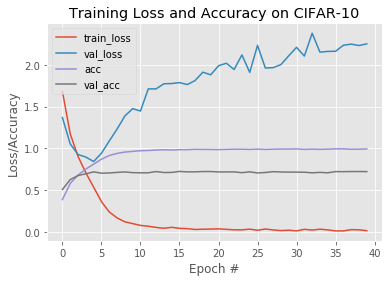

In [10]:
if __name__ == "__main__":
    (trainX, trainY), (testX, testY), labelNames = loadCifar()
    train1(trainX, trainY, testX, testY, labelNames=labelNames)

### 实验四：将FC换成GlobalAveragePooling

In [1]:
from models import MiniVGGNet
from keras.models import Model
from keras.layers import Input

Using TensorFlow backend.


#### 注意：   
#### You can't use model.layers.pop() to remove the last layer in the model. In tf.keras, model.layers will return a shallow copy version of the layers list, so actually you don't remove that layer, just remove the layer in the return value.

#### 参考：https://github.com/tensorflow/tensorflow/issues/22479  
#### https://github.com/keras-team/keras/issues/8772  
#### Remove and Add Layers in keras:  https://stackoverflow.com/questions/41668813/how-to-add-and-remove-new-layers-in-keras-after-loading-weights

In [14]:
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False

def build_fcn_model(lr=0.01, nesterov=True):
    net = MiniVGGNet.build(32, 32, 3, 10)
    for _ in range(7):
        pop_layer(net)
    net.add(AveragePooling2D((8,8)))
    net.add(Dense(10))
    net.add(Activation('softmax'))

    optimizer = SGD(lr=lr, momentum=0.9, decay=0.01/80, nesterov=nesterov)
    net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return net

In [15]:
net = build_fcn_model()

In [9]:
net = MiniVGGNet.build(32, 32, 3, 10)

In [10]:
for _ in range(7):
    pop_layer(net)
net.add(AveragePooling2D((8,8)))
net.add(Dense(10))
net.add(Activation('softmax'))

In [13]:
optimizer = SGD(lr=0.01, momentum=0.9, decay=0.01/80, nesterov=True)
net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [ ]:
def build_fcn_model(lr=0.01, nesterov=True)
    net = MiniVGGNet.build(32, 32, 3, 10)
    for _ in range(7):
        pop_layer(net)
    net.add(AveragePooling2D((8,8)))
    net.add(Dense(10))
    net.add(Activation('softmax'))

    optimizer = SGD(lr=lr, momentum=0.9, decay=0.01/80, nesterov=nesterov)
    net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
def train(model, trainX, trainY, testX, testY, lr=0.01, num_epochs=40, classes=10, labelNames=None):
    parallel_model = multi_gpu_model(model, gpus=2)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    print("[INFO] training network...")
    H = model.fit(trainX, trainY, 64, num_epochs, validation_data=(testX, testY), verbose=1)
    print("[INFO] evaluating network...")
    predictions = model.predict(testX, batch_size=128)
    print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(num_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(num_epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(num_epochs), H.history["acc"], label="acc")
    plt.plot(np.arange(num_epochs), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy on CIFAR-10")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("training_curve.png")



In [27]:
net.layers[-8].output

<tf.Tensor 'dropout_11/cond/Merge:0' shape=(?, 8, 8, 64) dtype=float32>

In [79]:
in_img = Input(shape=(32,32,3))
x = AveragePooling2D((8,8))(net.layers[-8].output)
x = Flatten()(x)
x = Dense(10)(x)
x = Activation('softmax')(x)
final_model = Model(inputs=in_img, outputs=[x]) ##报错..可能是Sequential和Model不能混用

TensorShape([Dimension(None), Dimension(10)])

In [50]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
model_5 (Model)              (None, 8, 8, 64)          66336     
_________________________________________________________________
average_pooling2d_9 (Average (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
_________________________________________________________________
activation_35 (Activation)   (None, 10)                0         
Total params: 66,986
Trainable params: 66,602
Non-trainable params: 384
_________________________________________________________________


In [ ]:
# model.add(AveragePooling2D(pool_size=(8, 8)))
# model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation('softmax'))

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13_input (InputLayer) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
__________

In [48]:
class MiniVGGNet:
    @staticmethod  # 静态方法: 无需实例化即可调用类中的方法
    def build(width, height, depth, classes):
        chanDim=-1
        inputShape=(height, width, depth)
        
        if K.image_data_format == "channel_first":
            inputShape = (depth, height, width)
            chanDim=1
        
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same',input_shape=inputShape))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(strides=2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(strides=2))
        model.add(Dropout(0.25))
        
        model.add(AveragePooling2D(pool_size=(8, 8)))
        model.add(Flatten())
        model.add(Dense(10))
        model.add(Activation('softmax'))
        return model

In [51]:
net = MiniVGGNet.build(32,32,3,10)

In [52]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_36 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_37 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
__________